There are parts of this code that are based on the keras example here: https://keras.io/examples/image_ocr/
Much of the image generation part was rewritten in Pillow instead of kairo. In hind site I should have tried to write it in keras or something that could be GPU accellerated.

In [ ]:
import sys
!{sys.executable} -m pip install pillow pydot matplotlib editdistance cairocffi editdistance graphviz scipy tensorflow-gpu keras

In [2]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import random

from matplotlib.pyplot import imshow
from PIL import Image

Using TensorFlow backend.


In [3]:
# List our avaialable devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import keras
print(keras.__version__)

# Check to make sure we are using a GPU (should show a GPY)
K.tensorflow_backend._get_available_gpus()

# # confirm TensorFlow sees the GPU
# from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# # confirm Keras sees the GPU
# from keras import backend
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# # confirm PyTorch sees the GPU
# from torch import cuda
# assert cuda.is_available()
# assert cuda.device_count() > 0
# print(cuda.get_device_name(cuda.current_device()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10064048844954983684
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14345158027244344507
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2689743937788557839
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6891035034
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1314334463572366843
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:0e:00.0, compute capability: 6.1"
]
2.3.1


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# Basic configuration
np.random.seed(123)

In [5]:
OUTPUT_DIR = 'model_weights'

# character classes and matching regex filter
regex = r'^[a-z ]+$'
alphabet = u'abcdefghijklmnopqrstuvwxyz '



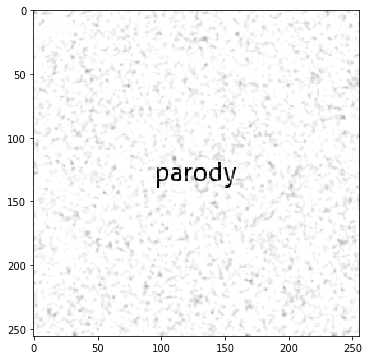

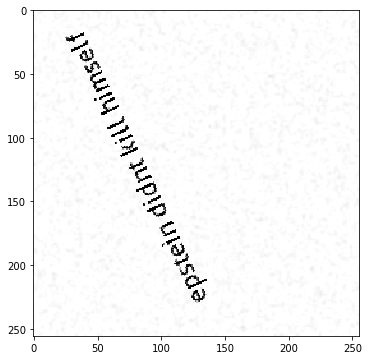

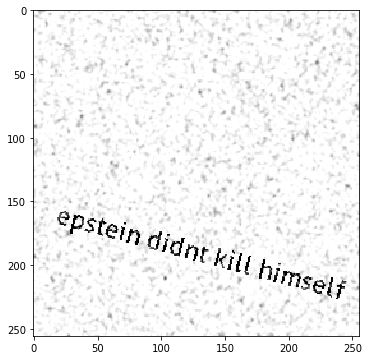

In [6]:
from PIL import Image, ImageDraw, ImageFont

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck

def draw_text(text, w, h, translate=True, rotate=True, multi_fonts=True, max_rotation=359):
    base_image = Image.new('RGB', (w,h), (255,255,255))

    #TODO download more fonts from fonts.google.com to support multiple fonts
    fnt = ImageFont.truetype('fonts/Aller_Rg.ttf', 20)
    text_dim = fnt.getsize(text)
    text_image = Image.new('RGBA', text_dim, (0,0,0,0))
    
    # Draw text
    d = ImageDraw.Draw(text_image)
    d.text((0,0), text, font=fnt, fill=(0,0,0))
    
    if(rotate):
        rotation_degrees = np.random.randint(-max_rotation, max_rotation)
        text_image = text_image.rotate(rotation_degrees, expand=1)
        
    
    if text_image.size[0] > base_image.size[0] or text_image.size[1] > base_image.size[1]:
        print( 'Text:' + text)
        print( 'Dimensions:' + str(text_image.size) + ', ' + str(base_image.size) )
        text_image.show()
        base_image.show()
        raise IOError('Text will not fit in image size. Increase image size or decrease max text length.')
    
    max_translate = tuple(t//2 for t in np.subtract(base_image.size, text_image.size))
    
    location = ((w - text_image.size[0])//2 ,(h - text_image.size[1])//2)
    if(translate):
        translate_x = np.random.randint(-max_translate[0],max_translate[0])
        translate_y = np.random.randint(-max_translate[1],max_translate[1])                                    
        location = (location[0] + translate_x, location[1] + translate_y)
    
    base_image.paste(text_image, location, text_image)
    
    a = np.array(base_image)
    a = a[:, :, 0]
    # Convert the 0-255 int value to float from 0-1 
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)
    a = speckle(a)
    
    return a


def show_single_channel_image(a):
    s = a.shape
    a = a.reshape((s[1],s[2]))
    plt.rcParams["figure.figsize"] = (6,6)
    plt.imshow(a, cmap='Greys_r')
    plt.show()
    
test_image = draw_text('parody',256, 256, translate=False, rotate=False)
show_single_channel_image(test_image)

test_image = draw_text('epstein didnt kill himself', 256, 256, translate=True, rotate=True)
show_single_channel_image(test_image)

test_image = draw_text('epstein didnt kill himself', 256, 256, translate=True, rotate=True, max_rotation=20)
show_single_channel_image(test_image)



In [7]:
# This is pulled from https://github.com/Tony607/keras-image-ocr
def shuffle_mats_or_lists(matrix_list, stop_ind=None):
    ret = []
    assert all([len(i) == len(matrix_list[0]) for i in matrix_list])
    len_val = len(matrix_list[0])
    if stop_ind is None:
        stop_ind = len_val
    assert stop_ind <= len_val

    a = list(range(stop_ind))
    np.random.shuffle(a)
    a += list(range(stop_ind, len_val))
    for mat in matrix_list:
        if isinstance(mat, np.ndarray):
            ret.append(mat[a])
        elif isinstance(mat, list):
            ret.append([mat[i] for i in a])
        else:
            raise TypeError('`shuffle_mats_or_lists` only supports '
                            'numpy.array and list objects.')
    return ret


# Translation of characters to unique integer values
def text_to_labels(text):
    ret = []
    for char in text:
        ret.append(alphabet.find(char))
    return ret


# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c == len(alphabet):  # CTC Blank
            ret.append("")
        else:
            ret.append(alphabet[c])
    return "".join(ret)


# only a-z and space..probably not to difficult
# to expand to uppercase and symbols

def is_valid_str(in_str):
    search = re.compile(regex, re.UNICODE).search
    return bool(search(in_str))


In [8]:
class DataProvider(keras.callbacks.Callback):
    def __init__(self, dictionary_file, minibatch_size,
                 img_w, img_h, downsample_factor, val_split,
                 absolute_max_string_len=16, max_rotation=180):

        self.minibatch_size = minibatch_size
        self.img_w = img_w
        self.img_h = img_h
        self.dictionary_file = dictionary_file
        self.downsample_factor = downsample_factor
        self.val_split = val_split
        self.blank_label = self.get_output_size() - 1
        self.absolute_max_string_len = absolute_max_string_len
        self.max_rotation = max_rotation

    def get_output_size(self):
        return len(alphabet) + 1

    # num_words can be independent of the epoch size due to the use of generators
    # as max_string_len grows, num_words can grow
    def build_word_list(self, num_words, max_string_len=None):
        # TODO this could be much smarter by finding a way to use google ngram api for data
        assert max_string_len <= self.absolute_max_string_len
        assert num_words % self.minibatch_size == 0
        assert (self.val_split * num_words) % self.minibatch_size == 0
        self.num_words = num_words
        self.string_list = [''] * self.num_words
        tmp_string_list = []
        
        self.max_string_len = max_string_len
        self.Y_data = np.ones([self.num_words, self.absolute_max_string_len]) * -1
        self.X_text = []
        self.Y_len = [0] * self.num_words

        
        with open(self.dictionary_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Remove newline characters and other characters that are unwanted like punctuation (\w)
        lines = map(lambda s : re.sub(r'[^\w]+', '', s.strip().lower() ), lines)
        
        # Filter ouf words over a specific length and words that are not part of our alphabet
        lines = [x for x in lines if len(x)<= self.max_string_len and is_valid_str(x) ]
        
        # Because many dictionaries are in an order(often alphebetical) randomize it.
        np.random.shuffle(lines)
        self.string_list = lines[:self.num_words]

        if len(self.string_list) != self.num_words:
            raise IOError('Not enough words in dictionary.')

        for i, word in enumerate(self.string_list):
            self.Y_len[i] = len(word)
            self.Y_data[i, 0:len(word)] = text_to_labels(word)
            self.X_text.append(word)
        self.Y_len = np.expand_dims(np.array(self.Y_len), 1)

        self.cur_val_index = self.val_split
        self.cur_train_index = 0

    # each time an image is requested from train/val/test, a new random
    # painting of the text is performed
    def get_batch(self, index, size, train):
        # width and height are backwards from typical Keras convention
        # because width is the time dimension when it gets fed into the RNN
        if K.image_data_format() == 'channels_first':
            X_data = np.ones([size, 1, self.img_w, self.img_h])
        else:
            X_data = np.ones([size, self.img_w, self.img_h, 1])

        labels = np.ones([size, self.absolute_max_string_len])
        input_length = np.zeros([size, 1])
        label_length = np.zeros([size, 1])
        source_str = []
        for i in range(size):
            # Mix in some blank inputs.  This seems to be important for
            # achieving translational invariance
            if train and i > size - 4:
                if K.image_data_format() == 'channels_first':
                    X_data[i, 0, 0:self.img_w, :] = self.paint_func('')[0, :, :].T
                else:
                    X_data[i, 0:self.img_w, :, 0] = self.paint_func('',)[0, :, :].T
                labels[i, 0] = self.blank_label
                input_length[i] = self.img_w // self.downsample_factor - 2
                label_length[i] = 1
                source_str.append('')
            else:
                if K.image_data_format() == 'channels_first':
                    X_data[i, 0, 0:self.img_w, :] = self.paint_func(self.X_text[index + i])[0, :, :].T
                else:
                    X_data[i, 0:self.img_w, :, 0] = self.paint_func(self.X_text[index + i])[0, :, :].T
                labels[i, :] = self.Y_data[index + i]
                input_length[i] = self.img_w // self.downsample_factor - 2
                label_length[i] = self.Y_len[index + i]
                source_str.append(self.X_text[index + i])
        inputs = {'the_input': X_data,
                  'the_labels': labels,
                  'input_length': input_length,
                  'label_length': label_length,
                  'source_str': source_str  # used for visualization only
                  }
        outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
        return (inputs, outputs)

    def next_train(self):
        while 1:
            ret = self.get_batch(self.cur_train_index, self.minibatch_size, train=True)
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= self.val_split:
                self.cur_train_index = self.cur_train_index % 32
                (self.X_text, self.Y_data, self.Y_len) = shuffle_mats_or_lists(
                    [self.X_text, self.Y_data, self.Y_len], self.val_split)
            yield ret

    def next_val(self):
        while 1:
            ret = self.get_batch(self.cur_val_index, self.minibatch_size, train=False)
            self.cur_val_index += self.minibatch_size
            if self.cur_val_index >= self.num_words:
                self.cur_val_index = self.val_split + self.cur_val_index % 32
            yield ret

    def on_train_begin(self, logs={}):
        self.build_word_list(16000, 6)
        self.paint_func = lambda text: draw_text(text, self.img_w, self.img_h,
                                                  rotate=False, translate=False, multi_fonts=False)

    def on_epoch_begin(self, epoch, logs={}):
        # rebind the paint function to implement curriculum learning
        if 3 <= epoch < 6:
            self.paint_func = lambda text: draw_text(text, self.img_w, self.img_h, rotate=False, translate=True, multi_fonts=False, max_rotation=self.max_rotation)
        elif 6 <= epoch < 9:
            self.paint_func = lambda text: draw_text(text, self.img_w, self.img_h, rotate=False, translate=True, multi_fonts=True, max_rotation=self.max_rotation)
        elif epoch >= 9:
            self.paint_func = lambda text: draw_text(text, self.img_w, self.img_h, rotate=True, translate=True, multi_fonts=True, max_rotation=self.max_rotation)
        if epoch >= 21 and self.max_string_len < 12:
            self.build_word_list(32000, 12)

In [9]:
# Exercise the data_provider to make sure its roughly working
def test_data_provider():
    pool_size = 2
    words_per_epoch = 16000
    val_split = 0.2
    val_words = int(words_per_epoch * (val_split))
    data_provider = DataProvider(dictionary_file='./dictionary.txt',
                                 minibatch_size=1000,
                                 img_w=256,
                                 img_h=256,
                                 downsample_factor=(pool_size ** 2),
                                 val_split=words_per_epoch - val_words)
    
    data_provider.build_word_list(16000, 6)
    print( len(data_provider.string_list) )
    print( data_provider.string_list[:10] )
    
    #print(data_provider.get_batch(0,32,))
    
    

test_data_provider()

16000
['didos', 'tess', 'havana', 'fart', 'azov', 'seraph', 'chests', 'flatly', 'relief', 'honeys']


In [10]:
# the actual loss calc occurs here despite it not being
# an internal Keras loss function

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

In [11]:
class VizCallback(keras.callbacks.Callback):

    def __init__(self, run_name, test_func, text_img_gen, num_display_words=6):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.text_img_gen = text_img_gen
        self.num_display_words = num_display_words
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def show_edit_distance(self, num):
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func, word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j], word_batch['source_str'][j])
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance: %.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        self.show_edit_distance(256)
        word_batch = next(self.text_img_gen)[0]
        res = decode_batch(self.test_func, word_batch['the_input'][0:self.num_display_words])
        if word_batch['the_input'][0].shape[0] < 256:
            cols = 2
        else:
            cols = 1
        for i in range(self.num_display_words):
            plt.subplot(self.num_display_words // cols, cols, i + 1)
            if K.image_data_format() == 'channels_first':
                the_input = word_batch['the_input'][i, 0, :, :]
            else:
                the_input = word_batch['the_input'][i, :, :, 0]
            plt.imshow(the_input.T, cmap='Greys_r')
            plt.xlabel('Truth = \'%s\'\nDecoded = \'%s\'' % (word_batch['source_str'][i], res[i]))
        fig = pylab.gcf()
        fig.set_size_inches(10, 13)
        plt.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
        plt.close()

In [12]:
def build_model(output_size, 
                absolute_max_string_len,
                img_w, img_h,
                pool_size,
                weight_file=None
               ):
    
    conv_filters = 16
    kernel_size = (3, 3)
    time_dense_size = 32
    rnn_size = 512
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
    print('input_shape='+str(input_shape))
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(output_size, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[absolute_max_string_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if(weight_file):
        model.load_weights(weight_file)
    
    test_func = K.function([input_data], [y_pred])
    
    return model, test_func

In [13]:
def train(run_name, start_epoch, stop_epoch, img_w, img_h, max_rotation):
    words_per_epoch = 16000
    val_split = 0.2
    val_words = int(words_per_epoch * (val_split))

    pool_size = 2
    minibatch_size = 32

    img_gen = DataProvider(dictionary_file="dictionary.txt",
                                 minibatch_size=minibatch_size,
                                 img_w=img_w,
                                 img_h=img_h,
                                 downsample_factor=(pool_size ** 2),
                                 val_split=words_per_epoch - val_words,
                                max_rotation=max_rotation
                                 )
    
    weight_file = None
    if start_epoch > 0:
        weight_file = os.path.join(OUTPUT_DIR, os.path.join(run_name, 'weights%02d.h5' % (start_epoch - 1)))
    
    model,test_func = build_model(output_size=img_gen.get_output_size(), 
                        absolute_max_string_len=img_gen.absolute_max_string_len,
                        img_w=img_w, img_h=img_h,
                        pool_size=pool_size,
                        weight_file=weight_file
                       )
    
    
    # captures output of softmax so we can decode the output during visualization
    #test_func = K.function([model.inputs], [model.outputs])

    viz_cb = VizCallback(run_name, test_func, img_gen.next_val())
    
    # TODO temporary debug visual
#     from keras.utils import plot_model
#     plot_model(model, to_file='model.png', show_shapes=True)

    model.fit_generator(generator=img_gen.next_train(),
                        steps_per_epoch=(words_per_epoch - val_words) // minibatch_size,
                        epochs=stop_epoch,
                        validation_data=img_gen.next_val(),
                        validation_steps=val_words // minibatch_size,
                        callbacks=[viz_cb, img_gen],
                        initial_epoch=start_epoch)

In [14]:
run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
train(run_name, 0, 20, 256,256,max_rotation=10)
# increase to wider images and start at epoch 10. The learned weights are reloaded
train(run_name, 20, 25, 512,256,max_rotation=10)

input_shape=(256, 256, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 16) 160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 128, 128, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 128, 128, 16) 2320        max1[0][0]                       
__________________________________________________________________

Epoch 21/25
400/400 [==============================] - 198s 496ms/step - loss: 1.4955 - val_loss: 2.0109

Out of 256 samples:  Mean edit distance: 0.605 Mean normalized edit distance: 0.115
Epoch 22/25
400/400 [==============================] - 197s 491ms/step - loss: 5.8054 - val_loss: 7.2284

Out of 256 samples:  Mean edit distance: 1.762 Mean normalized edit distance: 0.202
Epoch 23/25
400/400 [==============================] - 200s 501ms/step - loss: 4.7807 - val_loss: 6.2110

Out of 256 samples:  Mean edit distance: 1.762 Mean normalized edit distance: 0.205
Epoch 24/25
400/400 [==============================] - 203s 507ms/step - loss: 4.2538 - val_loss: 3.3411

Out of 256 samples:  Mean edit distance: 1.570 Mean normalized edit distance: 0.179
Epoch 25/25
400/400 [==============================] - 200s 499ms/step - loss: 3.8700 - val_loss: 3.7825

Out of 256 samples:  Mean edit distance: 1.434 Mean normalized edit distance: 0.159


In [75]:
run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
train(run_name, 0, 20, 192,192,max_rotation=3)
# increase to wider images and start at epoch 10. The learned weights are reloaded
train(run_name, 20, 25, 512,192,max_rotation=3)

input_shape=(192, 192, 1)
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 192, 192, 16) 160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 96, 96, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 96, 96, 16)   2320        max1[0][0]                       
_________________________________________________________________

Epoch 21/25
400/400 [==============================] - 194s 484ms/step - loss: 0.9236 - val_loss: 1.0185

Out of 256 samples:  Mean edit distance: 0.328 Mean normalized edit distance: 0.060
Epoch 22/25
400/400 [==============================] - 196s 489ms/step - loss: 5.0575 - val_loss: 4.4290

Out of 256 samples:  Mean edit distance: 1.586 Mean normalized edit distance: 0.174
Epoch 23/25
400/400 [==============================] - 196s 490ms/step - loss: 3.9224 - val_loss: 4.4828

Out of 256 samples:  Mean edit distance: 1.422 Mean normalized edit distance: 0.155
Epoch 24/25
400/400 [==============================] - 194s 486ms/step - loss: 3.2950 - val_loss: 4.1017

Out of 256 samples:  Mean edit distance: 1.113 Mean normalized edit distance: 0.121
Epoch 25/25
400/400 [==============================] - 195s 486ms/step - loss: 2.9528 - val_loss: 3.6249

Out of 256 samples:  Mean edit distance: 1.016 Mean normalized edit distance: 0.113


In [21]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      text = labels_to_text(lables)
      results.append(text)
    return results
  
def predit_a_image(model_p, a, top_paths = 1):
  c = np.expand_dims(a.T, axis=0)
  net_out_value = model_p.predict(c)
  top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
  return top_pred_texts

input_shape=(256, 256, 1)
Model: "model_110"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 16) 160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 128, 128, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 128, 128, 16) 2320        max1[0][0]                       
________________________________________________________________

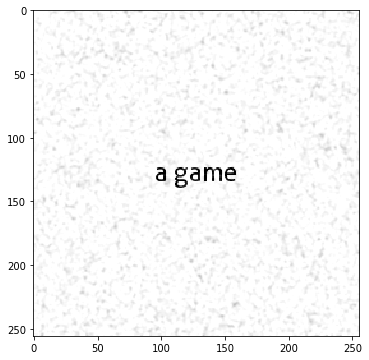

['agame']

In [60]:
def build_prediction_model(output_size, 
                absolute_max_string_len,
                img_w, img_h,
                pool_size,
                weight_file=None
               ):
    
    conv_filters = 16
    kernel_size = (3, 3)
    time_dense_size = 32
    rnn_size = 512
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
    print('input_shape='+str(input_shape))
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(output_size, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[absolute_max_string_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if(weight_file):
        model.load_weights(weight_file)
    
    test_func = K.function([input_data], [y_pred])
    
    return Model(inputs=input_data, outputs=y_pred)

w = 256
h = 256

model = build_prediction_model(output_size=len(alphabet) + 1, 
                        absolute_max_string_len=12,
                        img_w=w, img_h=h,
                        pool_size=2,
                        weight_file="best_weights.h5"
                       )

# model = Model(inputs=model.inputs[0], outputs=model.outputs[0])

a = draw_text('a game',h = h, w = w, max_rotation=3, rotate=False, translate=False)
b = a.reshape((h, w))
plt.imshow(b, cmap='Greys_r')
plt.show()

c = np.expand_dims(a.T, axis=0)

net_out_value = model.predict(c)
pred_texts = decode_predict_ctc(net_out_value)
pred_texts

In [62]:
predit_a_image(model, a, top_paths = 3)

['agame', 'gagame', 'ame']

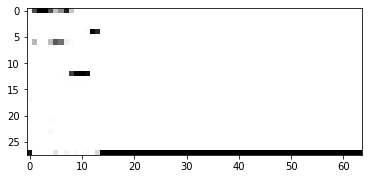

In [63]:
plt.imshow(net_out_value[0].T, cmap='binary', interpolation='nearest')
plt.show()